# Drivers of Flash Drought in Australia

This code aims to use the methods of Koster $ \textit{et al} $. (2019) to identify flash droughts in South Eastern Australia, and determine what drives them.

#### Flash Drought Defintion 

Flash drought is characterised by the sudden onset and rapid intensification of drought conditions. Following the definition of Koster $ \textit{et al} $. (2019) and in line with BoM - flash drought is definied as a reduction in soil moisture from above the 30th percentile to below its 10th percentile over a period of 20 days. This definition has been chosen for a specific area of analysis, namely SE Australia.  

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask.distributed as dsk

# Start Client/ dask runs together with xarray to improve performance. Only need to initialize once here.
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36125,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:34455,Total threads: 1
Dashboard: /proxy/39967/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41957,


In [2]:
# path to directory of AWRA model data
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/'

## Soil Moisture



In this section, for a given location with latitude and longitude (lat, lon), and a given day (d) of a year (y), the daily 30th and 10th percentiles of soil moisture are constructed. A 5 day window, (d-6, d-3, d, d+3, d+6), is used to construct the distrubution of the two quantiles over a selected period.

The quantiles vary across the period and are plotted together with the actual root zone soil moisture fraction/degree of saturation (W), in order to identify where flash droughts occur. 


Furthermore, this is tested using an empirical cumulative distribution function (CDF), with the same window, to convert W into a daily percentile, to see when and where it drops from above 30% to 10% in 20 days over a selected period. This is done to compare methods and validity. 

In [3]:
# extracting all files of sm_pct data. * tells you to take all similar files, here starting with 1(1980 etc) and 2(2022 etc)
# degree of saturation/soil moisture root zone(0-100cm) fraction (W)
sm_files = 'SCHEDULED-V6/processed/values/day/sm_pct_[1-2]*.nc'

#open a multifile dataset, from the same directory
ds_sm = xr.open_mfdataset(awra_dir + sm_files)

# selecting a time slice and specific latitude and longitude to work on a single grid cell
time_slice = slice('1980-01-01', '2022-12-31')
lat_sel = -37
lon_sel = 148

# data at a grid point and a specific time
da_sm = ds_sm.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_sm = da_sm.load()

# array of W
W = da_sm['sm_pct']
W

<xarray.DataArray 'sm_pct' (time: 15706)>
array([0.3933121 , 0.38873556, 0.4601209 , ..., 0.6302777 , 0.618378  ,
       0.7829461 ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [4]:
# using sm dataset to create a list of 6 days before, 3 days before, the day, 3 days after and 6 days after 
da_sm_6days_bef = da_sm.shift(time = -6) #after
da_sm_3days_bef = da_sm.shift(time = -3)
da_sm_6days_after = da_sm.shift(time = 6) #before
da_sm_3days_after = da_sm.shift(time = 3)

# 5 day window
da_list = [da_sm_6days_bef, da_sm_3days_bef, da_sm, da_sm_3days_after, da_sm_6days_after]

#concatate the data to create a dimension called window, which includes the 5 days in the list above
da_sm_withWindow = xr.concat(da_list, dim = 'window')

In [5]:
# using the window created above to calculate quantiles to identify FD
# create empty lists to save the calculated quantiles
list_da_quant = [] #for quantiles
list_doy = [] # for day of year

# for each doy, sample in the new dataset,now including the window, grouped by day of year
# create a list of the quantiles 0.1, 0.3 for each doy, using this window
for doy, sample in da_sm_withWindow.groupby('time.dayofyear'):
    da_quant_bydoy = sample.load().quantile([0.1, 0.3], dim=['time', 'window']) #sample. stores the quantiles in da_quant_bydoy for da_sm_withWindow. Need to keep definition of dimension for when working on larger datasets
    list_doy.append(doy) #.append adds items to list 
    list_da_quant.append(da_quant_bydoy)

In [6]:
# list_da_quant contains 366 elements - check with len(), with two quantile dimensions
# concatenate the data to create anotehr dimension named dayofyear from list_doy
ds_sm_pct_perc = xr.concat(list_da_quant, dim = 'dayofyear').assign_coords({'dayofyear': list_doy})

# create an array of the averaged/cumulative soil moisture quantiles for dayofyear (including leap years)
sm_perc = ds_sm_pct_perc['sm_pct']

In [7]:
# get an array of doy from the original dataset
da_sm_yr_doy = da_sm['time.dayofyear'].values#.values gets the values for the time.dayofyear in da_sm, aka 1 to 366

# using sm_perc, and renaming dayofyear time, assigning new coordinates to look over multiple years, and not just the averaged 366 days
da_sm_10p = sm_perc.sel(quantile = 0.1, dayofyear = da_sm_yr_doy) #0.1 quantile for same period as soil moisture)
da_sm_10p = da_sm_10p.rename({'dayofyear':'time'}).assign_coords({'time': da_sm.time.values})

da_sm_30p = sm_perc.sel(quantile = 0.3, dayofyear = da_sm_yr_doy)
da_sm_30p = da_sm_30p.rename({'dayofyear':'time'}).assign_coords({'time': da_sm.time.values})

### FD Identification using the 0.1 and 0.3 quantile against W

Text(0.5, 0, 'Time')

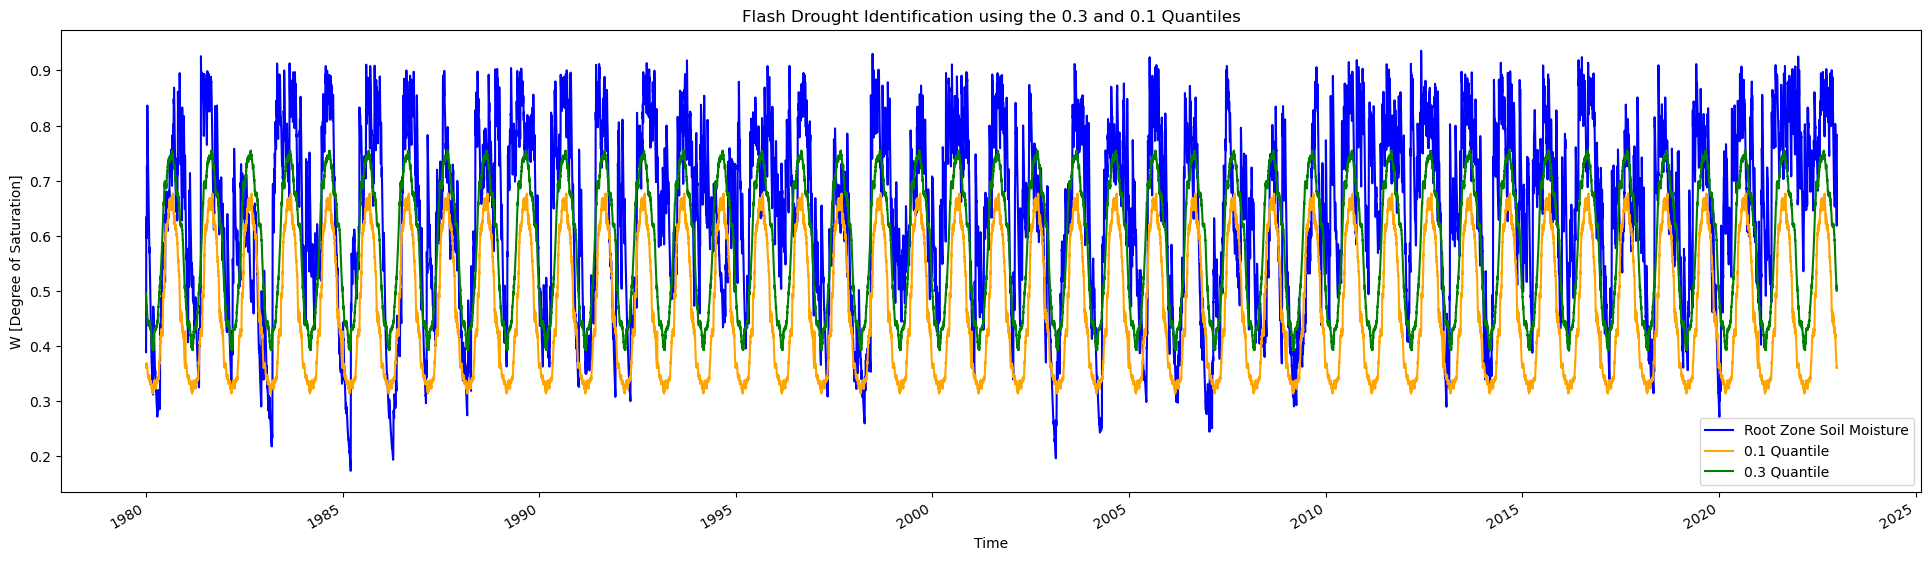

In [8]:
# using the built in plt for xarray, plotting a line plot with sm data, 0.1 and 0.3 quantile
da_sm['sm_pct'].plot( c = 'b', size = 6, aspect = 4, label = 'Root Zone Soil Moisture')
da_sm_10p.plot(c= 'orange', label = '0.1 Quantile')
da_sm_30p.plot(c = 'g', label = '0.3 Quantile')
plt.legend()
plt.title('Flash Drought Identification using the 0.3 and 0.1 Quantiles') 
plt.ylabel('W [Degree of Saturation]')
plt.xlabel('Time')

This plots the soil misture percentage (blue) against the 0.1th (orange) and 0.3th quantile (green). Showing seasonal variation in degree of saturation and the respective quantiles. Furthermore we need to filter out the FD events with some more criteria. 

$ 1. $ $  \textbf{W} $ has to be above the 30th percentile before the onset of a flash drought $$ $$
$ 2. $ $  \textbf{W} $ then has to drop to 10% after 20 days 

In [9]:
# criteria 1 : SM above 30%

da_sm_gt_30p = da_sm['sm_pct'].where(da_sm['sm_pct'] >= da_sm_30p)

In [10]:
#criteria 2: SM has to drop below 10% within 20 days 
#in this code we check that it is below 10% after 20 days, but not in shorter periods

da_sm_after_20days = W.shift(time = -20) # soil moisture20 days after 
da_sm_after_20days_lt_10p = da_sm_after_20days.where(da_sm_after_20days <= da_sm_10p) #20 days after where below or equal 10%

Text(0.5, 0, 'Time')

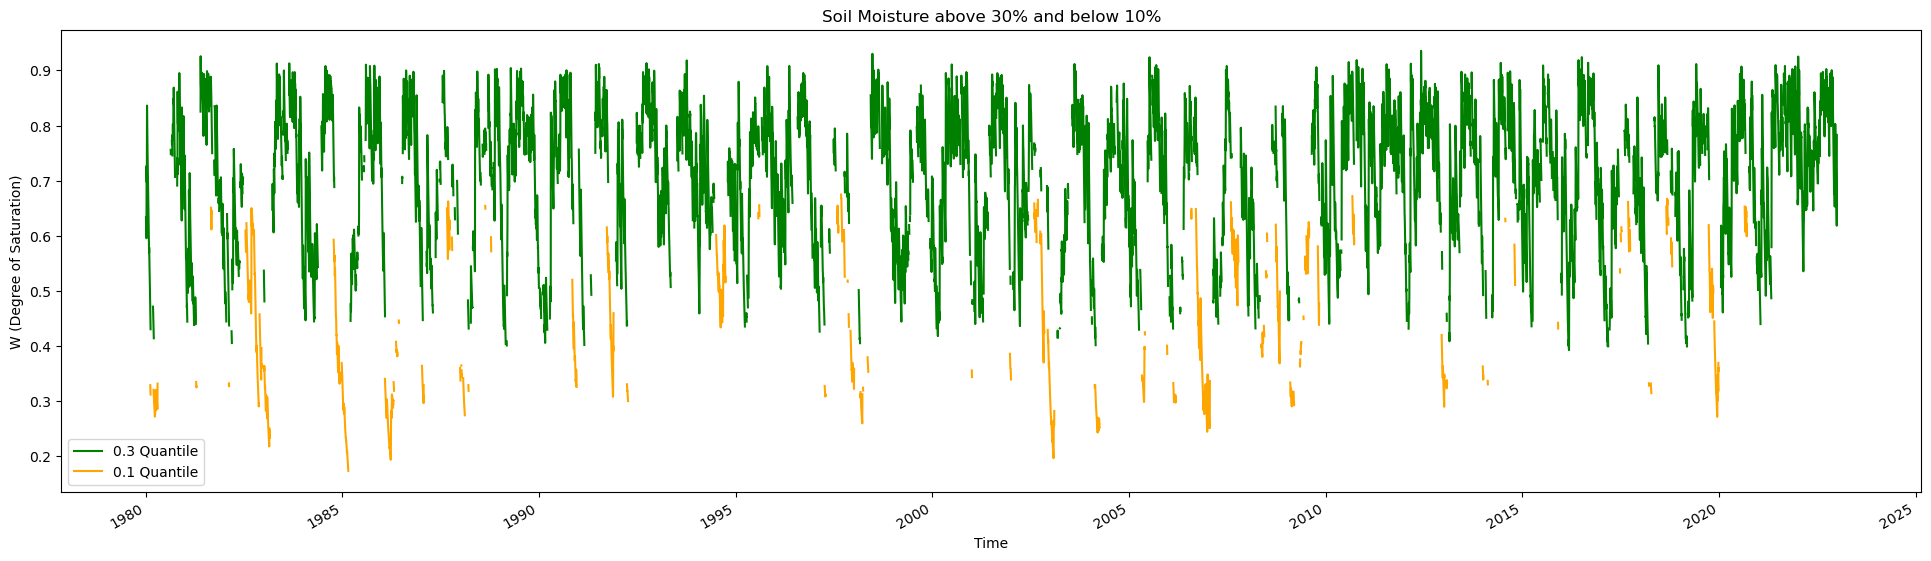

In [11]:
# plot of where soil moisture is above 30% and where it is below 10% after 20 days
da_sm_gt_30p.plot(size = 6, aspect = 4, color = 'g', label = '0.3 Quantile' )
da_sm_after_20days_lt_10p.plot(color= 'orange', label = '0.1 Quantile' )
plt.legend()
plt.title('Soil Moisture above 30% and below 10%') 
plt.ylabel('W (Degree of Saturation)')
plt.xlabel('Time')

This plot shows where the soil moisture is above 30% (green) and then is below 10%. The 0.1th quantile has been shifted 20 days forward, so that we now can check when we have values above the 0.3th quantile and below 0.1th 20 days later. 

In [12]:
da_sm_flash_drght = da_sm_gt_30p.where(~np.isnan(da_sm_after_20days_lt_10p)) 
#tilde ~ is a compliment operator, returning the "opposite" of what you specify
#Here it returns values that are not nan. So sm above 30% where sm is below 10% after 20 days

# check if there are any values
da_sm_flash_drght.dropna(dim = 'time') #dropna removes nan values

<xarray.DataArray 'sm_pct' (time: 253)>
array([0.46706906, 0.45450217, 0.44225353, 0.430588  , 0.4373876 ,
       0.4300193 , 0.42290324, 0.41427493, 0.8798313 , 0.8725773 ,
       0.8664178 , 0.8523685 , 0.8389571 , 0.82591724, 0.8126395 ,
       0.79971373, 0.45638034, 0.44675967, 0.43744496, 0.5249146 ,
       0.51401335, 0.50403607, 0.4932586 , 0.48106632, 0.7831875 ,
       0.8399566 , 0.740067  , 0.72621715, 0.7127925 , 0.6996095 ,
       0.7072943 , 0.6997415 , 0.6883816 , 0.5014634 , 0.465316  ,
       0.45401633, 0.5359161 , 0.5233712 , 0.5108828 , 0.49892032,
       0.48759782, 0.47686535, 0.4659138 , 0.4566048 , 0.44717303,
       0.76194465, 0.7972459 , 0.78688365, 0.7744438 , 0.7715388 ,
       0.76873636, 0.75744116, 0.74656254, 0.7392561 , 0.69008386,
       0.71261215, 0.7099019 , 0.45527714, 0.44773698, 0.43990728,
       0.7825749 , 0.7708006 , 0.7466457 , 0.7331517 , 0.7212822 ,
       0.66962546, 0.65772897, 0.64805824, 0.66269237, 0.68068224,
       0.6932143 , 0.678127  , 0.66215146, 0.64829737, 0.635784  ,
       0.6228961 , 0.8481398 , 0.8323962 , 0.8181475 , 0.8053171 ,
       0.8043821 , 0.79118514, 0.777686  , 0.7641035 , 0.7503321 ,
       0.73692894, 0.72280526, 0.71122193, 0.69755465, 0.44486275,
       0.4388627 , 0.7986841 , 0.7918182 , 0.7502103 , 0.7090441 ,
       0.71627253, 0.70396185, 0.70634985, 0.6902184 , 0.65969646,
...
       0.74232644, 0.72827166, 0.71358794, 0.7000661 , 0.70600116,
       0.7159651 , 0.70237267, 0.68870133, 0.8199361 , 0.80393696,
       0.7873476 , 0.7720433 , 0.7563086 , 0.74975955, 0.7388592 ,
       0.72376126, 0.7088821 , 0.69490314, 0.7116456 , 0.7047815 ,
       0.69546723, 0.8785596 , 0.8782431 , 0.8659873 , 0.8584315 ,
       0.8468578 , 0.8586374 , 0.84417677, 0.8309503 , 0.82084286,
       0.80745494, 0.79485124, 0.7818946 , 0.7690006 , 0.7561421 ,
       0.74325895, 0.7306466 , 0.5705522 , 0.5553499 , 0.5403737 ,
       0.5421179 , 0.45879292, 0.44584495, 0.57238185, 0.52737534,
       0.5139532 , 0.5046187 , 0.49253306, 0.77828693, 0.767366  ,
       0.7826303 , 0.76765   , 0.75045943, 0.7410243 , 0.73919773,
       0.7221756 , 0.7067655 , 0.7961131 , 0.7830966 , 0.7788173 ,
       0.76609606, 0.7544816 , 0.7559451 , 0.74443436, 0.78312975,
       0.7700329 , 0.7600046 , 0.74729514, 0.7343441 , 0.7627965 ,
       0.76183105, 0.7502041 , 0.7730779 , 0.760399  , 0.74836403,
       0.68090814, 0.68441665, 0.6789986 , 0.75810146, 0.7407788 ,
       0.7260738 , 0.7174442 , 0.4997457 , 0.781096  , 0.7548665 ,
       0.74207544, 0.7294847 , 0.71625614, 0.70274   , 0.80903995,
       0.8384531 , 0.82410043, 0.81056255, 0.799359  , 0.7866246 ,
       0.7737336 , 0.76180303, 0.7503128 ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-13 1980-02-14 ... 2020-09-04
    latitude   float64 -37.0
    longitude  float64 148.0
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

Text(0.5, 0, 'Time')

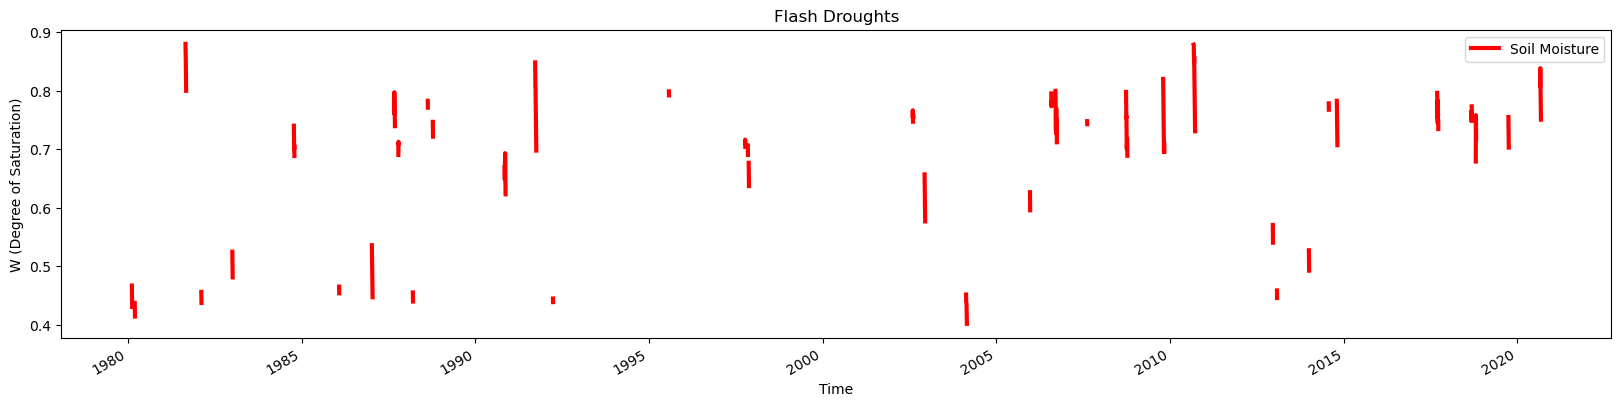

In [13]:
# plot of the flash drought events for a selected time slice 
da_sm_flash_drght.sel(time = time_slice).plot(size = 4, aspect= 5, linewidth = '3', linestyle = 'solid', c = 'r', label = 'Soil Moisture')
plt.legend()
plt.title('Flash Droughts') 
plt.ylabel('W (Degree of Saturation)')
plt.xlabel('Time')

This plot has now identified potential start dates for flash droughts. The "lines" indicate that we have multiple FD start dates in a row. Hopefully these can be filtered out using the next criteria. Below I have saved the above array as a netcdf file to be used for filtering more. It has nan-values for the days that are not considered potential FD start dates.

In [14]:
# save the calculated FD start day data to a netcdf file for future use

# first give some attributes 
da_sm_flash_drght.name = 'sm_pct'
da_sm_flash_drght.attrs['long_name'] = 'Total rootzone soil moisture (0-100 cm)'
da_sm_flash_drght.attrs['units'] = 'Fraction of fullness'

da_sm_flash_drght

out_dir = '/g/data/w97/aj8747/fd_summer_project/'
out_file = 'fd_sm_start_dates.nc'
da_sm_flash_drght.to_netcdf(out_dir + out_file)

## Identifying FD using ECDF

In [15]:
from statsmodels.distributions.empirical_distribution import ECDF

In [16]:
#create an empty list for the function

ecdf_fn_list = []

#doy_sel = 30 #unsure why we chose this value?

#converting the 5 day window into an array of 366 days for the whole time slice
doy_array = da_sm_withWindow['time.dayofyear']

for doy_sel in range(1, 367): 
    da_sm_sel = da_sm_withWindow.where(doy_array == doy_sel) #why doy_sel?
    da_sm_sel_nonNan = da_sm_sel['sm_pct'].values #using the previous window created for the 5 days, extracting the values of sm_pct
    da_sm_sel_nonNan = da_sm_sel_nonNan[~np.isnan(da_sm_sel_nonNan)] #selecting where the above is not nan 
    ecdf = ECDF(da_sm_sel_nonNan) #creating a cumulative distributive function for each value that is not nan
    ecdf_fn_list.append(ecdf) #put these values into a list

In [17]:
# coverting soil mositure to percentiles

#list to store percentiles
sm_perc_list = []

#select single year
year_sel = '1987'
da_sm_sel = da_sm.sel(time = slice(year_sel, year_sel))

for doy, perc_fn in zip(da_sm_sel['time.dayofyear'].values, ecdf_fn_list):
    da_temp = da_sm_sel['sm_pct'].where(da_sm_sel['time.dayofyear'] == doy)
    temp_array = da_temp.values
    temp_array = temp_array[~np.isnan(temp_array)]
    
    sm_perc = perc_fn(temp_array)
    sm_perc_list.append(sm_perc)

In [18]:
# sm_perc_list is an array inside an array. In order to extract it into an array, we use a for loop

#new empty list
sm_perc_list2 = []

for i in sm_perc_list: #for index in first list
    sm_perc_list2.append(i[0]) #add first entry [0] of index to new list

In [19]:
# create a new array from the list of percentiles, with time dimension and cordinates from da_sm_sel)
da_sm_asPerc = xr.DataArray(sm_perc_list2, dims = ['time'], coords = {'time': da_sm_sel.time.values})

Text(0.5, 0, 'Time')

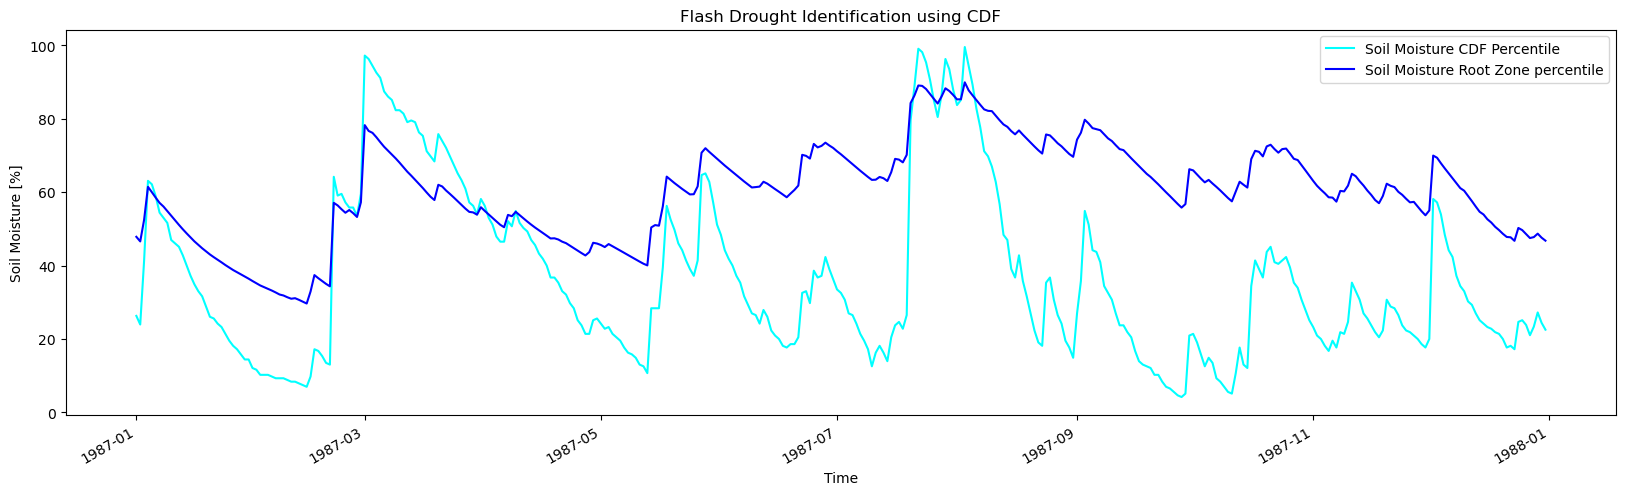

In [20]:
# now plotting in percentage
(da_sm_asPerc*100).plot(size = 5, aspect = 4, color = 'cyan', label = 'Soil Moisture CDF Percentile') #CDF%
(da_sm_sel['sm_pct']*100).plot(color = 'blue', label = 'Soil Moisture Root Zone percentile') #W
plt.legend()
plt.title('Flash Drought Identification using CDF') 
plt.ylabel('Soil Moisture [%]')
plt.xlabel('Time')

The constructed CDF soil moisture percentile (cyan) plotted against the actual root zone soil moisture percentage (blue) for a selected time (x-axis). 

However, we do not need the actual soil moisture percentage, only to identify where the CDF drops from 30% to 10% within 20 days, as calcualted before. 

In [21]:
# Criteria 1: SM% above 30%

da_sm_ecdf_30p = da_sm_asPerc.where(da_sm_asPerc >= 0.3) #convert back to years? Now it is 366 days

In [22]:
#criteria 2: SM has to drop below 10% within 20 days 

da_sm_ecdf_20days = da_sm_asPerc.shift(time = -20) # sm% 20 days after 
da_sm_20days_ecdf_10p = da_sm_ecdf_20days.where(da_sm_ecdf_20days <= 0.1) #20 days after where below or equal 10%

Text(0.5, 0, 'Time')

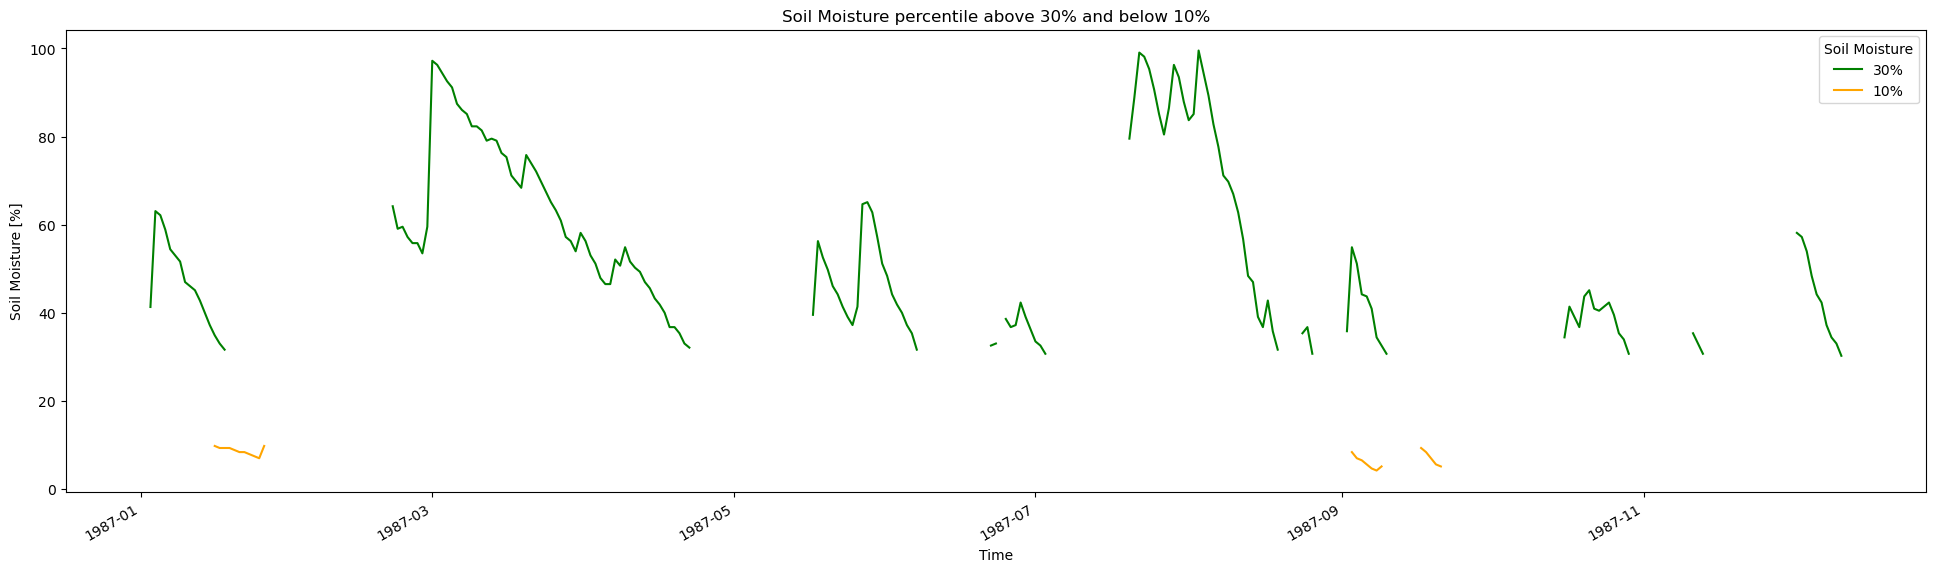

In [23]:
# plot of where soil moisture is above 30% and where it is below 10% after 20 days
(da_sm_ecdf_30p*100).plot(size = 6, aspect = 4, color = 'g', label = '30%')
(da_sm_20days_ecdf_10p*100).plot(color= 'orange', label = '10%')
plt.legend(title = 'Soil Moisture')
plt.title('Soil Moisture percentile above 30% and below 10%') 
plt.ylabel('Soil Moisture [%]')
plt.xlabel('Time')

For the same period investigated using the 0.1th and 0.3th quantile, the CDF is used to plot the percentile drop from 30% to 10% 20 days later. One possible flash drought event has been identified mid-January for 1987. Now to see if it is valid:

In [24]:
da_sm_flash_drght_ecdf = da_sm_ecdf_30p.where(~np.isnan(da_sm_20days_ecdf_10p)) 
da_sm_flash_drght_ecdf.dropna(dim = 'time')

<xarray.DataArray (time: 10)>
array([0.34883721, 0.33023256, 0.31627907, 0.54883721, 0.51162791,
       0.44186047, 0.4372093 , 0.40930233, 0.34418605, 0.3255814 ])
Coordinates:
  * time     (time) datetime64[ns] 1987-01-16 1987-01-17 ... 1987-09-09

Text(0.5, 0, 'Time')

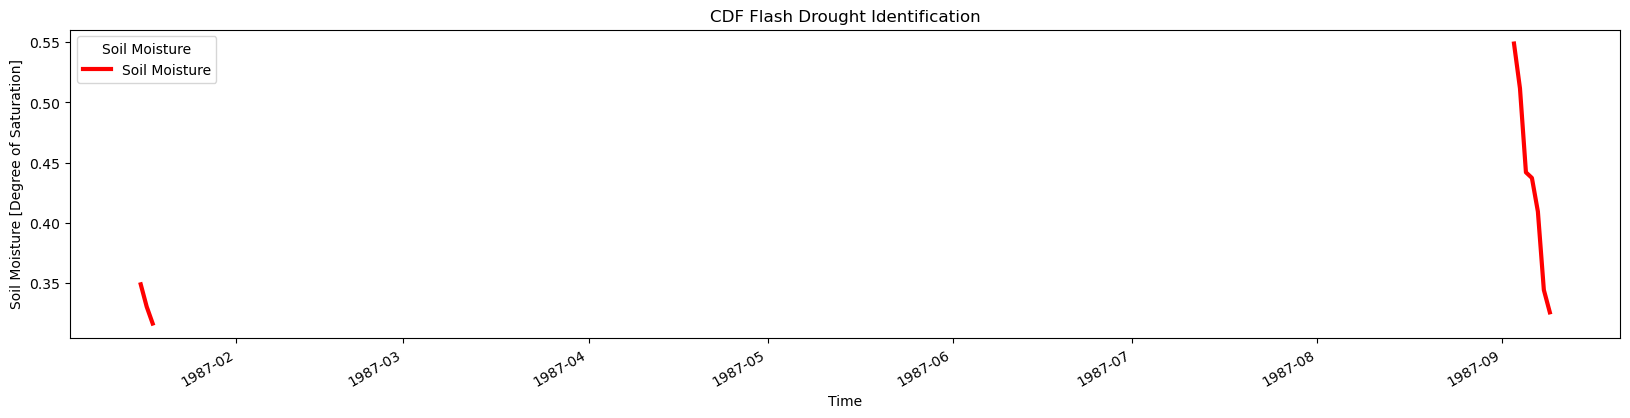

In [25]:
da_sm_flash_drght_ecdf.plot(size = 4, aspect= 5, linewidth = '3', linestyle = 'solid', c = 'r', label = 'Soil Moisture')
plt.legend(title = 'Soil Moisture')
plt.title('CDF Flash Drought Identification') 
plt.ylabel('Soil Moisture [Degree of Saturation]')
plt.xlabel('Time')

Unsure if this plot is correct? Anjana is checking if percentile methods match

Now to check if the FD identified with the quantiles matches the FD identified using ECDF:

Text(0.5, 0, 'Time')

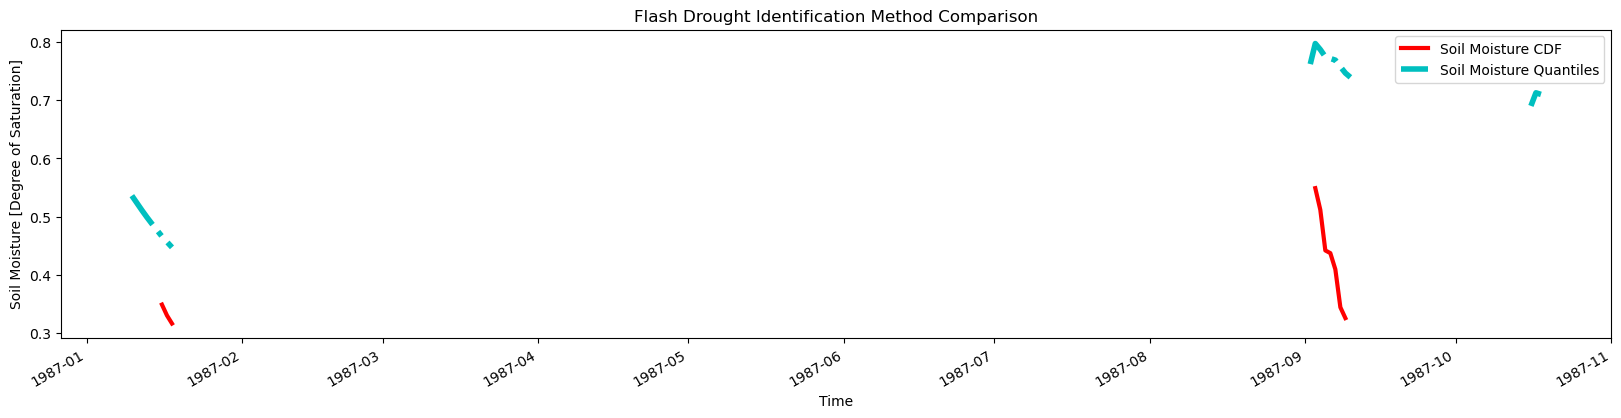

In [26]:
da_sm_flash_drght_ecdf.plot(size = 4, aspect= 5, linewidth = '3', linestyle = 'solid', c = 'r', label = 'Soil Moisture CDF')
da_sm_flash_drght.sel(time = slice('1987', '1987')).plot( linewidth = '4', linestyle = 'dashdot', c = 'c', label = 'Soil Moisture Quantiles')
plt.legend()
plt.title('Flash Drought Identification Method Comparison') 
plt.ylabel('Soil Moisture [Degree of Saturation]')
plt.xlabel('Time')

Some inconsistencies with teh two methods, but unsure which one. Anjana is looking.

### Soil Moisture Climatology

In [27]:
# Using 'groupby' group SM array by day of year and take the mean
sm_climatology = W.groupby('time.dayofyear').mean()

# Calculate the SM anomaly by taking the original ET and subtracting the climatology
sm_anomaly = W.groupby('time.dayofyear') - sm_climatology

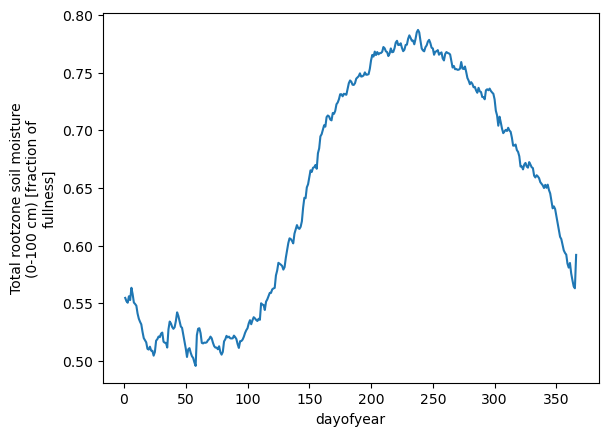

In [28]:
sm_climatology.plot()

## Precipitation

In [29]:
# defining the directory of all rain_day files
precip_dir = '/g/data/fj8/BoM/AWRA/DATA/CLIMATE/rain_day/rain_day_*.nc'

# defining the multifile dataset
ds_p = xr.open_mfdataset(precip_dir, chunks = {'time':'200mb'}, parallel = True)

In [30]:
# data at a grid point and a specific time
da_p = ds_p.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_p = da_p.load()

#array of P
P = da_p['rain_day']

In [31]:
# plot W and P together

## Evapotranspiration

In [32]:
etot_dir = awra_dir + 'SCHEDULED-V6/etot_*.nc'

In [33]:
ds_et = xr.open_mfdataset(etot_dir, chunks = {'time':'200mb'}, parallel = True)

In [34]:
# data at a grid point and a specific time
da_et = ds_et.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_et = da_et.load()

#array of ET
ET = da_et['etot']

### Constructing a climatology

In [35]:
# define a climatology group for our time_slice, group by day of year. (this is already daily data)
et_clim = da_et.sel(time= time_slice).groupby('time.dayofyear')

In [36]:
%time # check how long the code takes to run

# empty lists for et values with years in 366 groups
list_doy2 = []
list_et_clim = []

# for loop to run through et_clim for dayofyear over the time slice and create a list with 366 elements, each with 43 years in its dimension
# second list has 366 elements for each dayofyear
for doy2, sample2 in et_clim:
    et_clim_bydoy = sample2.load()
    list_doy2.append(doy2)
    list_et_clim.append(et_clim_bydoy)

#list_et_clim

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


In [37]:
# lis_et_clim is now a list of 366 values with a time dimension of 43 years. Concatate data to give a new dimension named dayofyear
ds_et_clim= xr.concat(list_et_clim, dim = 'dayofyear').assign_coords({'dayofyear': list_doy2})

#take the mean of the 43 years, to get the climatology over the 366 days of the year
ds_et_climat = ds_et_clim.mean('time')

Text(0.5, 0, 'Day of Year')

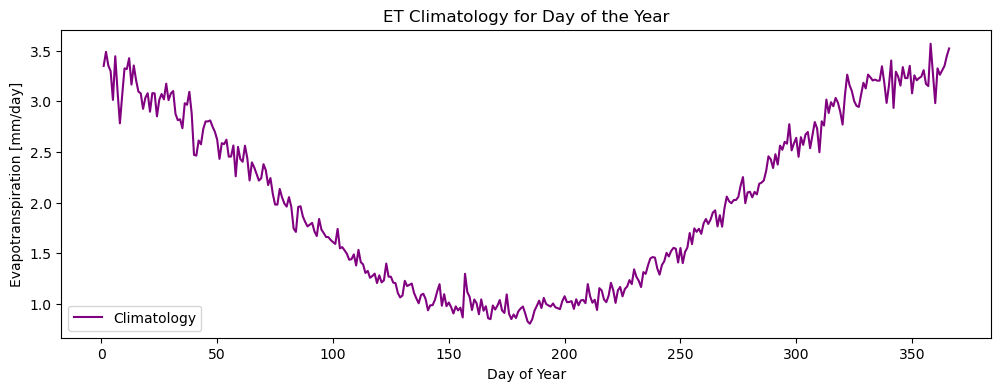

In [38]:
# plot the ET Climatology for dayofyear
ds_et_climat['etot'].plot( size = 4, aspect = 3, label = 'Climatology', c = 'purple')
plt.legend()
plt.title('ET Climatology for Day of the Year') 
plt.ylabel('Evapotranspiration [mm/day]')
plt.xlabel('Day of Year')

Climatology looks good! ET is higher in the summer months and lowest in the winter months.

In [39]:
# Create an array for dayofyear for the ET data
da_et_yr_doy = da_et['time.dayofyear'].values
da_et_yr_doy

array([  1,   2,   3, ..., 363, 364, 365])

In [40]:
# Changing coordinates back to the same as the original dataset, daily instead of dayofyear
ds_et_climate = ds_et_climat.sel(dayofyear = da_et_yr_doy)
ds_et_climate = ds_et_climate.rename({'dayofyear':'time'}).assign_coords({'time': da_et.time.values})

Text(0.5, 0, 'Time')

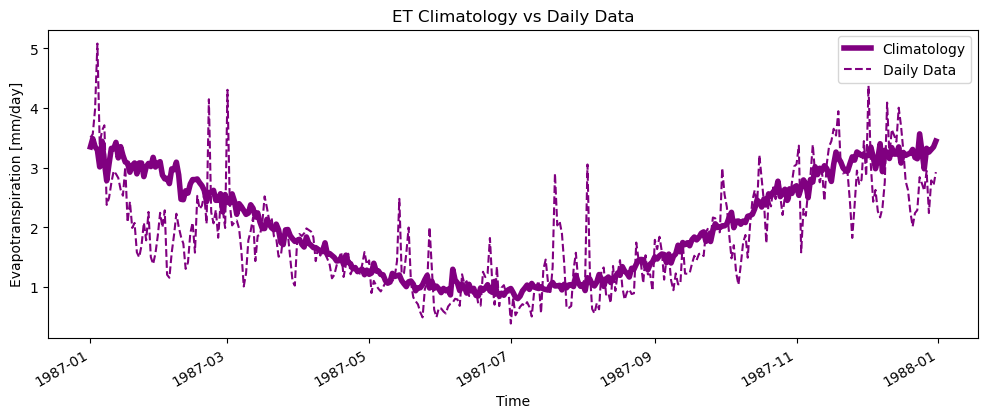

In [41]:
# plot of climatology vs daily data, to see where flash drought occurs
ds_et_climate['etot'].sel(time = slice( '1987','1987')).plot(color = 'purple', linewidth = 4, size = 4, aspect = 3, label = 'Climatology')
da_et['etot'].sel(time = slice( '1987','1987')).plot( color = 'purple', linestyle='dashed', label = 'Daily Data')
plt.legend()
plt.title('ET Climatology vs Daily Data') 
plt.ylabel('Evapotranspiration [mm/day]')
plt.xlabel('Time')

We see a significant drop in ET in January 1987, which is when the SM matches the criteria for a flash drought. However, the ET also has criteria that needs to be met in order for this event to be classified as a flash drought

### Another way of constructing the ET climatology

In [42]:
#do_et = ET.groupby('time.dayofyear').mean().data

In [43]:
# Using 'groupby' group ET array by day of year and take the mean
et_climatology = ET.groupby('time.dayofyear').mean()

# Calculate the ET anomaly by taking the original ET and subtracting the climatology
et_anomaly = ET.groupby('time.dayofyear') - et_climatology

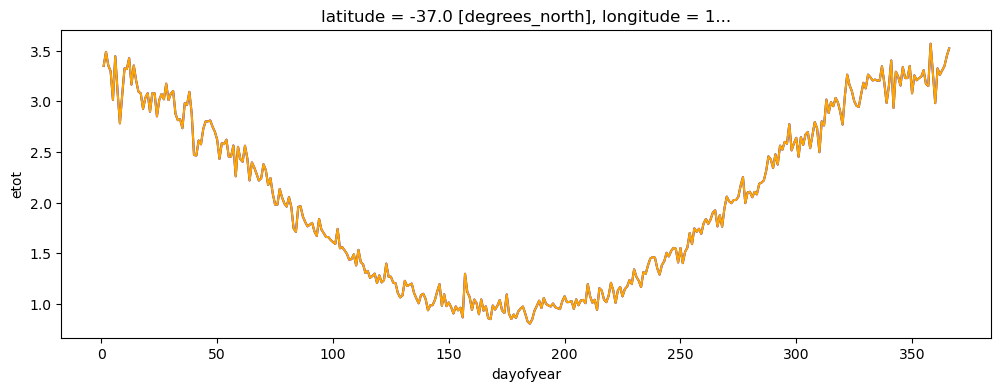

In [44]:
# plot the two climatologies together to check that they are the same
et_climatology.plot(color = 'blue', size = 4, aspect = 3)
ds_et_climat['etot'].plot(color = 'orange')

The climatologies are exactly the same. For information, the new et_climatology could be used further, but needs to reassign coordinates in order to plot with daily data.

Text(0.5, 1.0, 'ET anomaly')

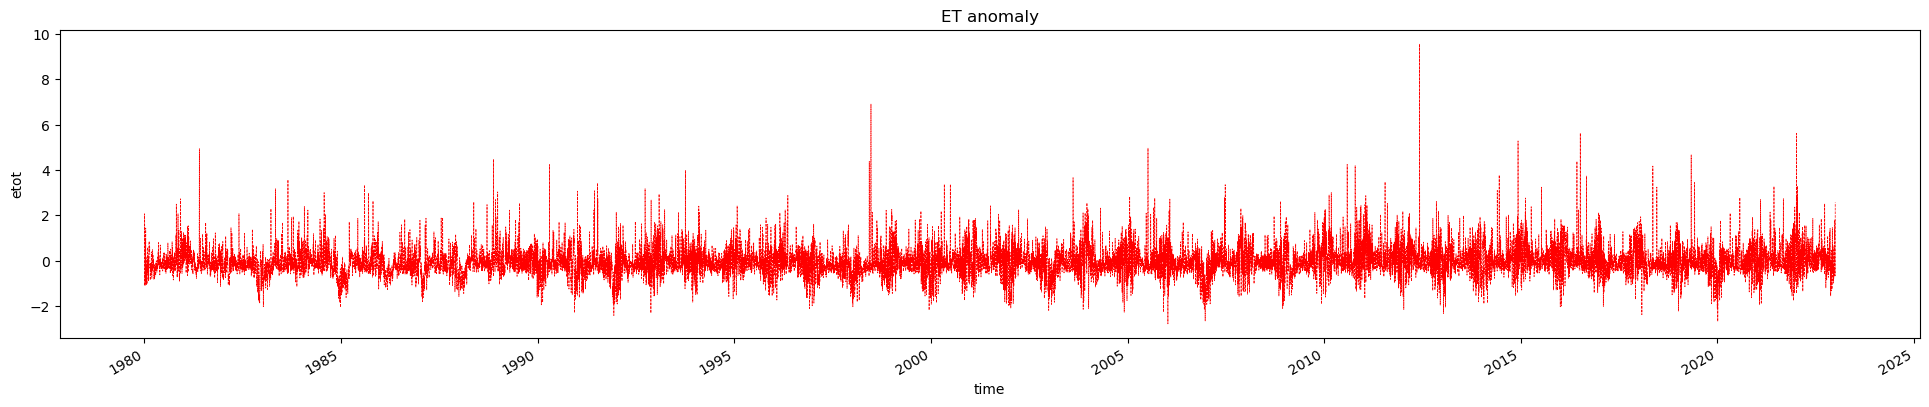

In [45]:
# plot of the anomlay for a selected period
et_anomaly.sel(time = time_slice).plot( color = 'red', linestyle='dashed', linewidth = 0.5, size = 4, aspect = 6)
plt.title( "ET anomaly")

#### ET Criteria

To further filter out flash droughts, the ET has to meet four different criteria

$ 1. $ $  \textbf{ET} $ 20 days prior to the 20 day flash drought period must be 4/5 of the climatological average or higher $$ $$
$ 2. $ $  \textbf{ET} $ in the 20 days after the FD period has to fall below 3/5 of the climatological average $$ $$
$ 3. $  Climatological $  \textbf{ET} $ must be above 0.2 mm/day (SE AUS drier) in the flash drought window $$ $$
$ 4. $ These 60 day periods cannot overlap

In [47]:
# 1. Criteria: ET 20 days prior to flash drought onset must be 4/5 of the climatological avg or higher
da_et_20daysprior = da_et.shift(time = 20) #20 days prior to identified flashdrought events
da_et_first_crit_frac = da_et_20daysprior.where(da_et_20daysprior >= 0.8*ds_et_climate) #20 days prior where et is equal or above climatological avg
da_et_first_crit= da_et_first_crit_frac.where(~np.isnan(da_sm_flash_drght)) #where the criteria above matches the onset of a flash drought
da_et_first_crit

<xarray.Dataset>
Dimensions:    (time: 15706)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Data variables:
    etot       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    var_name:  etot

In [ ]:
#
da_et_1crit = da_et.where(da_et >= 0.8*ds_et_climate)

In [97]:
import datetime
da_sm_flash_drght['time'].dt.floor('D')[0]

<xarray.DataArray 'floor' ()>
array('1980-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 1980-01-01
    latitude   float64 -37.0
    longitude  float64 148.0

In [131]:
#test_date = da_sm_flash_drght['time'].dt.floor('D')[0]

def date_20(date):

    t = []
    for i in range(1, 21):
        ti = date - np.timedelta64(i, 'D')
        t.append(ti)
    
    return t
tt = date_20(da_sm_flash_drght['time'].dt.floor('D')[0])
tt

[<xarray.DataArray 'floor' ()>
 array('1979-12-31T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1980-01-01
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1979-12-30T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1980-01-01
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1979-12-29T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1980-01-01
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1979-12-28T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1980-01-01
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1979-12-27T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1980-01-01
 

In [114]:
test_date = da_sm_flash_drght
test_date[0]


<xarray.DataArray 'sm_pct' ()>
array(nan, dtype=float32)
Coordinates:
    time       datetime64[ns] 1980-01-01
    latitude   float64 -37.0
    longitude  float64 148.0
Attributes:
    name:           sm_pct
    units:          Fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [147]:
et_crit_1_data= []
et_crit_1_dates= []

flash_drght_test = da_sm_flash_drght

for date in da_sm_flash_drght.dropna(dim ='time')["time"].dt.floor("D"):

    #sm_20prior = da_et_first_crit_frac.sel( time = date)['etot'].values
    
    dt20 = date_20(date)
    dt = np.empty(20)
    dt[:] = np.nan
    
    i = 0
    for t in dt20:
        sm_20prior = da_et_first_crit_frac.sel( time = t)['etot']
        dt[i] = sm_20prior
        i+=1
    dt = dt[~np.isnan(dt)]
    
    if len(dt) >= 20:
        et_crit_1_data.append(dt)
        et_crit_1_dates.append(dt20)

In [152]:
ds = xr.Dataset(
    data_vars=dict(
        variable=(["x"], et_crit_1_data)
    ),
    coords=dict(
        lon=148.0,
        lat=-37.0,
        time=et_crit_1_dates.values,
    ),
    attrs=dict(description='text'),
)

AttributeError: 'list' object has no attribute 'values'

In [148]:
et_crit_1_data[0]

array([2.91069117, 3.01016062, 2.98163456, 2.77410389, 2.64037095,
       2.73608702, 2.97848676, 3.10916456, 3.88753071, 2.99932108,
       3.17677578, 3.74029211, 3.21777173, 3.74832835, 2.98363865,
       3.67694296, 3.42546901, 2.82189414, 2.46888565, 3.21049473])

In [146]:
et_crit_1_dates[0]

[<xarray.DataArray 'floor' ()>
 array('1986-01-27T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1986-01-28
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1986-01-26T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1986-01-28
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1986-01-25T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1986-01-28
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1986-01-24T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1986-01-28
     latitude   float64 -37.0
     longitude  float64 148.0,
 <xarray.DataArray 'floor' ()>
 array('1986-01-23T00:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time       datetime64[ns] 1986-01-28
 

In [71]:
da_sm_flash_drght.dropna(dim ='time')["time"].dt.floor("D")

<xarray.DataArray 'floor' (time: 253)>
array(['1980-02-13T00:00:00.000000000', '1980-02-14T00:00:00.000000000',
       '1980-02-15T00:00:00.000000000', '1980-02-16T00:00:00.000000000',
       '1980-03-14T00:00:00.000000000', '1980-03-15T00:00:00.000000000',
       '1980-03-16T00:00:00.000000000', '1980-03-17T00:00:00.000000000',
       '1981-08-30T00:00:00.000000000', '1981-08-31T00:00:00.000000000',
       '1981-09-01T00:00:00.000000000', '1981-09-02T00:00:00.000000000',
       '1981-09-03T00:00:00.000000000', '1981-09-04T00:00:00.000000000',
       '1981-09-05T00:00:00.000000000', '1981-09-06T00:00:00.000000000',
       '1982-02-12T00:00:00.000000000', '1982-02-13T00:00:00.000000000',
       '1982-02-14T00:00:00.000000000', '1983-01-04T00:00:00.000000000',
       '1983-01-05T00:00:00.000000000', '1983-01-06T00:00:00.000000000',
       '1983-01-07T00:00:00.000000000', '1983-01-08T00:00:00.000000000',
       '1983-08-05T00:00:00.000000000', '1984-10-05T00:00:00.000000000',
       '1984-10-12T00:00:00.000000000', '1984-10-13T00:00:00.000000000',
       '1984-10-14T00:00:00.000000000', '1984-10-15T00:00:00.000000000',
       '1984-10-16T00:00:00.000000000', '1984-10-17T00:00:00.000000000',
       '1984-10-18T00:00:00.000000000', '1986-01-28T00:00:00.000000000',
       '1986-01-31T00:00:00.000000000', '1986-02-01T00:00:00.000000000',
       '1987-01-10T00:00:00.000000000', '1987-01-11T00:00:00.000000000',
       '1987-01-12T00:00:00.000000000', '1987-01-13T00:00:00.000000000',
...
       '2017-09-11T00:00:00.000000000', '2017-09-12T00:00:00.000000000',
       '2017-09-13T00:00:00.000000000', '2017-09-14T00:00:00.000000000',
       '2017-09-15T00:00:00.000000000', '2017-09-16T00:00:00.000000000',
       '2017-09-17T00:00:00.000000000', '2017-09-18T00:00:00.000000000',
       '2017-09-20T00:00:00.000000000', '2017-09-21T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-09-02T00:00:00.000000000',
       '2018-09-03T00:00:00.000000000', '2018-09-07T00:00:00.000000000',
       '2018-09-08T00:00:00.000000000', '2018-09-09T00:00:00.000000000',
       '2018-10-13T00:00:00.000000000', '2018-10-17T00:00:00.000000000',
       '2018-10-20T00:00:00.000000000', '2018-10-21T00:00:00.000000000',
       '2018-10-22T00:00:00.000000000', '2018-10-23T00:00:00.000000000',
       '2018-10-24T00:00:00.000000000', '2019-01-14T00:00:00.000000000',
       '2019-09-26T00:00:00.000000000', '2019-09-28T00:00:00.000000000',
       '2019-09-29T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-10-02T00:00:00.000000000',
       '2020-08-27T00:00:00.000000000', '2020-08-28T00:00:00.000000000',
       '2020-08-29T00:00:00.000000000', '2020-08-30T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-09-02T00:00:00.000000000', '2020-09-03T00:00:00.000000000',
       '2020-09-04T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1980-02-13 1980-02-14 ... 2020-09-04
    latitude   float64 -37.0
    longitude  float64 148.0

In [68]:
et_crit_1_dates[0]
da_et_first_crit_frac.sel( time =et_crit_1_dates[0])['etot'].values.type()

IndexError: list index out of range

In [47]:
da_et_20daysprior['etot']#.plot()

<xarray.DataArray 'etot' (time: 15706)>
array([       nan,        nan,        nan, ..., 2.94337986, 3.91968481,
       2.40351346])
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Attributes:
    long_name:      etot
    units:          mm
    name:           etot
    standard_name:  etot

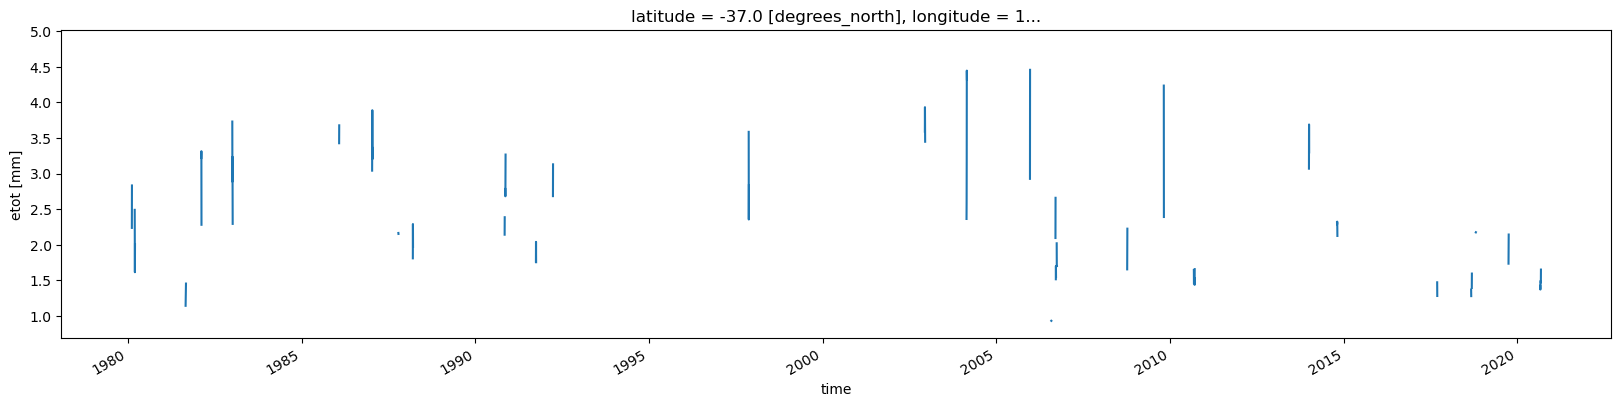

In [48]:
da_et_first_crit['etot'].plot(size=4, aspect = 5)

This plot shows the 20 day periods before the onset of a flash drought where ET is 4/5 of the cliamtological avg

In [49]:
# 2. Criteria: ET 20 days after flash drought 20 day window must be below 3/5 of the climatological avg

In [50]:
da_et_40daysafter = da_et.shift(time = -40) #40 days after the start of the 60 day window
da_et_sec_crit_frac = da_et_40daysafter.where(da_et_40daysafter < 0.6*ds_et_climate)#40 days after where et is below climatological avg

# where the criteria above matches the end of a flash drought period
print(da_et_sec_crit_frac.dropna(dim = 'time'))

<xarray.Dataset>
Dimensions:    (time: 2680)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-15 1980-01-16 ... 2022-08-26
    latitude   float64 -37.0
    longitude  float64 148.0
Data variables:
    etot       (time) float64 1.819 1.613 1.791 1.553 ... 0.5424 0.5502 0.8079
Attributes:
    var_name:  etot


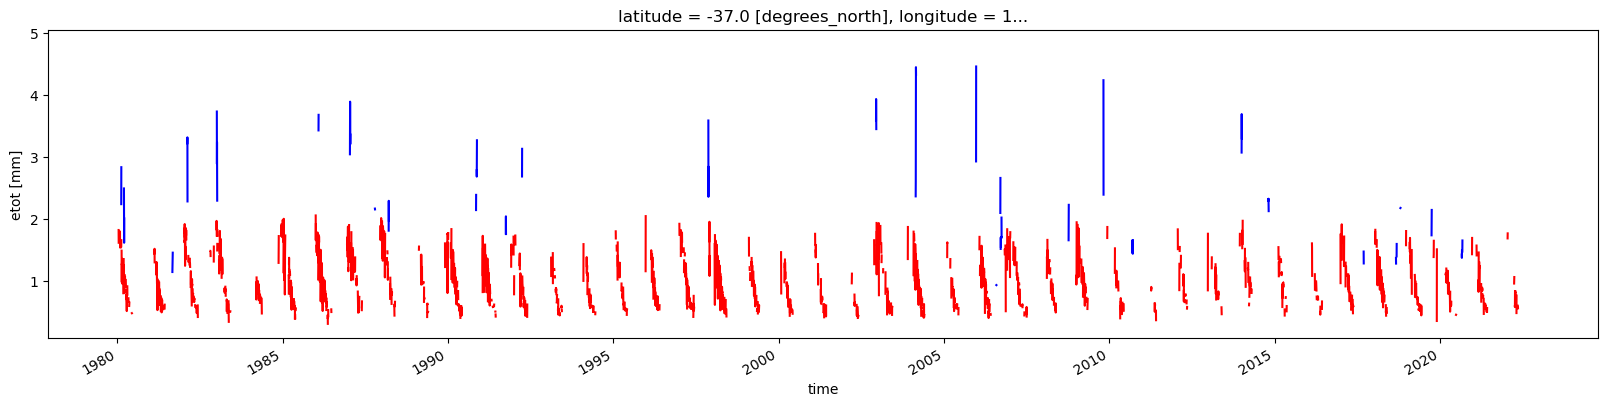

In [51]:
#plot comparing the ET criteria
da_et_first_crit['etot'].plot( color = 'b', size = 4, aspect = 5)
da_et_sec_crit_frac['etot'].plot( color = 'r')

In [52]:
#where the first criteria matches where the second criteria is not nan, because we've brought it forwards 40 days.
#while we've moved the first criteria back 20 days!
da_et_both_crit= da_et_first_crit.where(~np.isnan(da_et_sec_crit_frac))

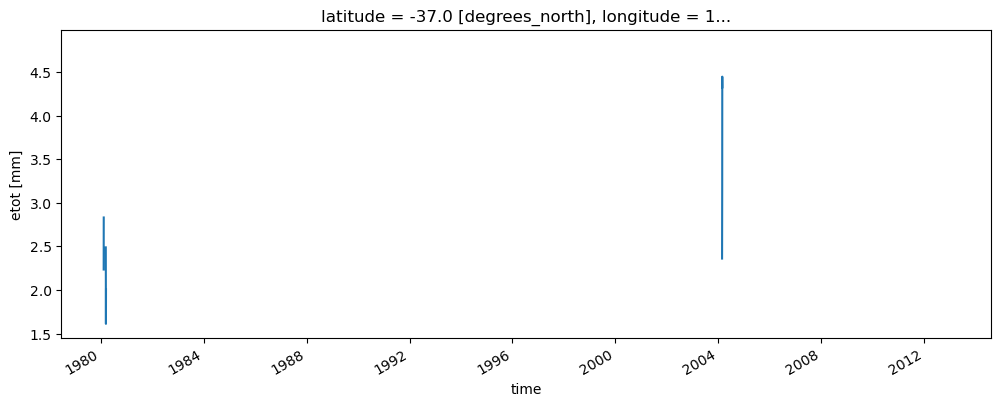

In [53]:
da_et_both_crit['etot'].plot(size=4, aspect = 3)

For the selected cell we only have two FD that match the above criteria

In [54]:
# 3. Criteria: Climatological ET must be above 0.2 mm/day (SE AUS drier) in the flash drought window

In [55]:
clim_et_crit = da_et_both_crit.where(ds_et_climate > 0.2)
clim_et_crit.dropna(dim ='time')

<xarray.Dataset>
Dimensions:    (time: 20)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-13 1980-02-14 ... 2012-12-18
    latitude   float64 -37.0
    longitude  float64 148.0
Data variables:
    etot       (time) float64 2.236 2.832 2.489 1.819 ... 4.446 4.323 4.822
Attributes:
    var_name:  etot

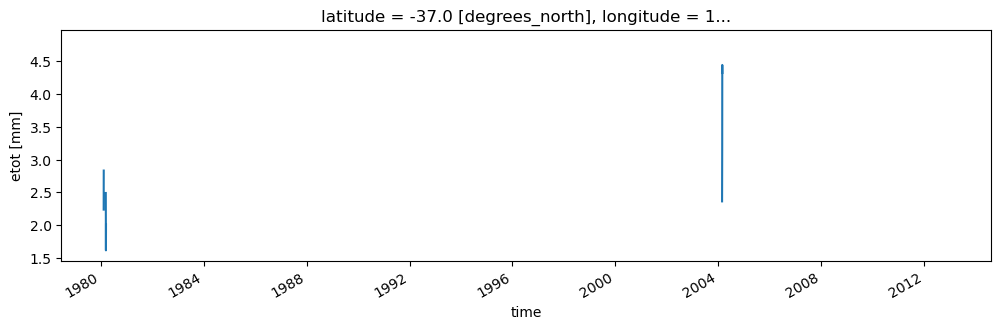

In [56]:
clim_et_crit['etot'].plot(size = 3, aspect = 4)

In [57]:
# No periods can overlap within these 60 days!

In [58]:
fd_60 = clim_et_crit.shift(time= -60) #60 days after
fd_overlap = clim_et_crit.where(~np.isnan(fd_60)) #where they overlap

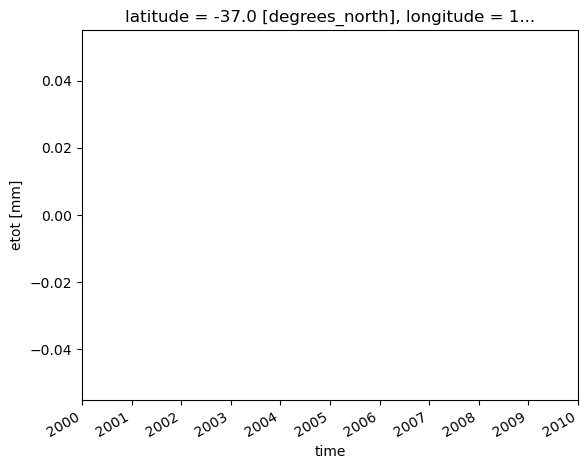

In [59]:
fd_overlap['etot'].plot()

## Scatter plot for ET vs W

In [60]:
et_vs_w = xr.merge([da_et, da_sm], join = 'outer')
et_vs_w

<xarray.Dataset>
Dimensions:    (time: 15706)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
    latitude   float64 -37.0
    longitude  float64 148.0
Data variables:
    etot       (time) float64 2.307 2.606 3.518 5.368 ... 2.686 2.689 6.015
    sm_pct     (time) float32 0.3933 0.3887 0.4601 ... 0.6303 0.6184 0.7829
Attributes:
    var_name:  etot

In [61]:
df_et_w = et_vs_w.to_dataframe(dim_order = ['time']) #'latitude', 'longitude'])
df_et_w

,latitude,longitude,etot,sm_pct
time,,,,
1980-01-01,-37.0,148.0,2.306564,0.393312
1980-01-02,-37.0,148.0,2.605615,0.388736
1980-01-03,-37.0,148.0,3.518020,0.460121
1980-01-04,-37.0,148.0,5.368407,0.634131
1980-01-05,-37.0,148.0,3.738397,0.619533
...,...,...,...,...
2022-12-27,-37.0,148.0,5.122071,0.650977
2022-12-28,-37.0,148.0,2.952645,0.637079
2022-12-29,-37.0,148.0,2.686275,0.630278


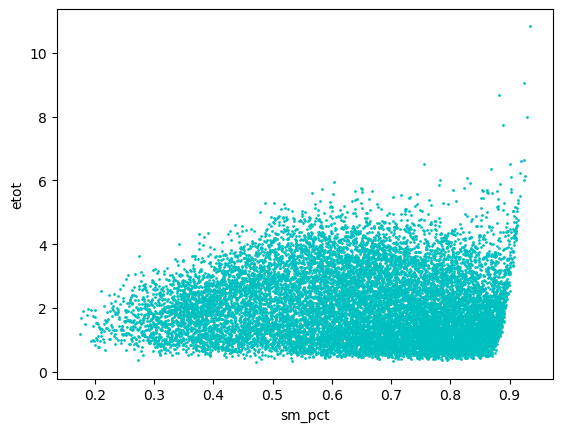

In [62]:
#scatter plot of the relationship between etot and sm in our 43 year period
scatter_et_w = df_et_w.plot.scatter( y ='etot', x ='sm_pct', s=1, c='c', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None)

In [63]:
# Add in fd datapoints 
fd_sm_et = xr.merge([da_sm_flash_drght, clim_et_crit['etot']], join = 'outer')

In [64]:
fd_datapoints = fd_sm_et.to_dataframe( dim_order = ['time'])
print(fd_datapoints.dropna())

            latitude  longitude    sm_pct      etot
time                                               
1980-02-13     -37.0      148.0  0.467069  2.235671
1980-02-14     -37.0      148.0  0.454502  2.832013
1980-03-14     -37.0      148.0  0.437388  2.489358
1980-03-15     -37.0      148.0  0.430019  1.818783
1980-03-16     -37.0      148.0  0.422903  1.612867
1980-03-17     -37.0      148.0  0.414275  2.006337
1983-01-08     -37.0      148.0  0.481066  2.292144
1986-01-28     -37.0      148.0  0.501463  3.210495
1986-01-31     -37.0      148.0  0.465316  3.425469
1987-01-16     -37.0      148.0  0.465914  3.319706
1990-11-09     -37.0      148.0  0.662692  3.495989
1992-03-28     -37.0      148.0  0.444863  2.682146
2002-12-13     -37.0      148.0  0.591811  3.471781
2004-02-17     -37.0      148.0  0.451745  3.751257
2004-02-22     -37.0      148.0  0.434734  2.361240
2004-02-23     -37.0      148.0  0.425690  2.600142
2004-02-24     -37.0      148.0  0.417100  3.180974
2004-02-25  

In [65]:
#import matplotlib.pyplot as plt
#
#for col in df_et_w.columns:
#    plt.scatter(df_et_w.loc[:,["etot", 'sm_pct']], fd_datapoints.loc[:,["etot", 'sm_pct']], label=col)
#plt.legend(loc='best', fontsize=16)
#plt.xlabel('sm_pct')
#plt.ylabel('etot')

<AxesSubplot:xlabel='sm_pct', ylabel='etot'>

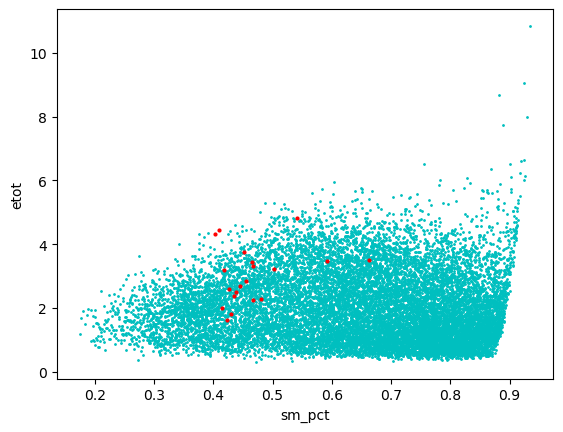

In [66]:
scatter_et_w = df_et_w.plot.scatter( y ='etot', x ='sm_pct', s=1, c='c', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None)
fd_datapoints.plot.scatter(ax=scatter_et_w, y ='etot', x ='sm_pct', s=4, c='r')

Right plot, but you need the daily data for a 20 day period! and to make this plot for a smaller period

#### Scatter plot of ET W relationship including an identified flash drought (20 daily values) 

In this section, a scatterplot is produced from creating dataframes for an identified 20 day flash drought period. Found after filtering through all the FD criteria, and thus finding the start day for a flash drought. The values might drop more in subsequent days, but for the purpose of identifying these periods, we stick to analysing the 20 day window. 